In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap, re, joblib

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

%matplotlib inline

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [2]:
# Load data
data = pd.read_csv(r"C:\Users\HP\Downloads\Hostel_Prices.csv")

print("Data shape:", data.shape)
data.head(3)

Data shape: (502, 30)


,gender,age_group,level_of_study,lecture_location,accommodation_type,faculty,off_campus_duration,room_category,annual_rent,includes_water,...,room_size,furnished_bed,furnished_table,furnished_chairs,has_access_controls,has_janitorial_services,required_deposit,recent_rent_increase,avg_rent_nearby,hostel_location
0,Male,25-30,Postgraduate,Science,2 in a room,Faculty of Social Sciences,Less than 6 months,Shared washroom- shared kitchen,4000.0,No,...,20 - 30 sqm,Yes,Yes,Yes,Yes,No,2500.0,500.0,5000.0,Kwaprow
1,Male,35-40,Postgraduate,New Site,Private room(1 in a room),School of Business,3 years or more,Full self contain,5000.0,Yes,...,15 - 20 sqm,Yes,NaN,NaN,No,No,2500.0,1500.0,4000.0,Amamoma
2,Male,25-30,Postgraduate,Science,Private room(1 in a room),Faculty of Social Sciences,6 months to 1 year,Full self contain,4500.0,No,...,15 - 20 sqm,Yes,Yes,Yes,No,No,2500.0,1000.0,3500.0,Domeabra


### Exploratory Data Analysis (EDA)

In [3]:
# Displaying basic information about the dataset
print("Dataset Info:")
data.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      480 non-null    object 
 1   age_group                   502 non-null    object 
 2   level_of_study              500 non-null    object 
 3   lecture_location            500 non-null    object 
 4   accommodation_type          501 non-null    object 
 5   faculty                     501 non-null    object 
 6   off_campus_duration         501 non-null    object 
 7   room_category               500 non-null    object 
 8   annual_rent                 500 non-null    float64
 9   includes_water              500 non-null    object 
 10  includes_electricity        499 non-null    object 
 11  includes_waste_disposal     501 non-null    object 
 12  has_running_water           500 non-null    object 
 13  has_extra_storage    

In [4]:
# Displaying summary statistics for numerical columns
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
        annual_rent  required_deposit  recent_rent_increase  avg_rent_nearby
count    500.000000        500.000000            494.000000       497.000000
mean    2896.400000       1950.300000            544.878543      2568.394366
std     1418.644474       1080.240134            386.140582      1386.046186
min      400.000000        200.000000              0.000000       190.000000
25%     2000.000000       1200.000000            400.000000      1680.000000
50%     2500.000000       1550.000000            500.000000      2145.000000
75%     3000.000000       2000.000000            500.000000      3000.000000
max    12000.000000       7000.000000           4200.000000      9000.000000


In [5]:
# Checking for missing values
print("\nMissing Values Count:")
print(data.isnull().sum())


Missing Values Count:
gender                        22
age_group                      0
level_of_study                 2
lecture_location               2
accommodation_type             1
faculty                        1
off_campus_duration            1
room_category                  2
annual_rent                    2
includes_water                 2
includes_electricity           3
includes_waste_disposal        1
has_running_water              2
has_extra_storage              8
has_wifi_internet             16
has_study_area                 9
has_security_services         13
has_generator_backup_power     9
hostel_distance_minutes        0
commute_mode                   1
room_size                      0
furnished_bed                  0
furnished_table                2
furnished_chairs               3
has_access_controls           12
has_janitorial_services       10
required_deposit               2
recent_rent_increase           8
avg_rent_nearby                5
hostel_location     

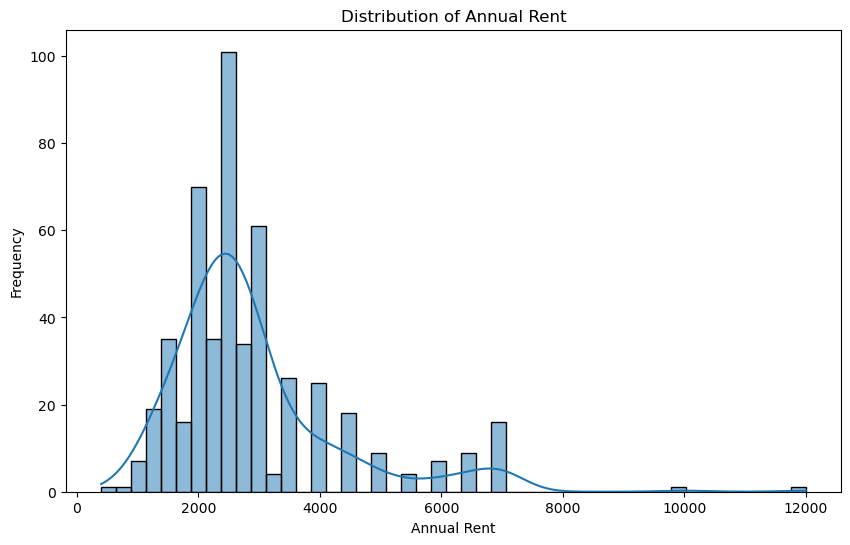

In [6]:
# Visualizing distribution of the target variable 'annual_rent'
plt.figure(figsize=(10, 6))
sns.histplot(data['annual_rent'], kde=True)
plt.title('Distribution of Annual Rent')
plt.xlabel('Annual Rent')
plt.ylabel('Frequency')
plt.show()

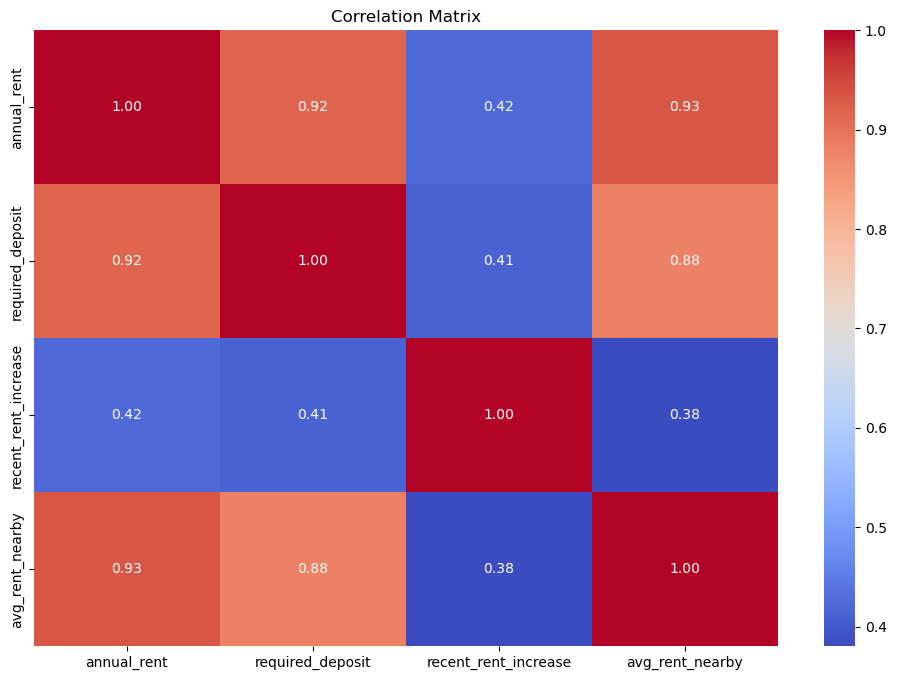

In [7]:
# Correlation matrix for numerical features
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = data[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

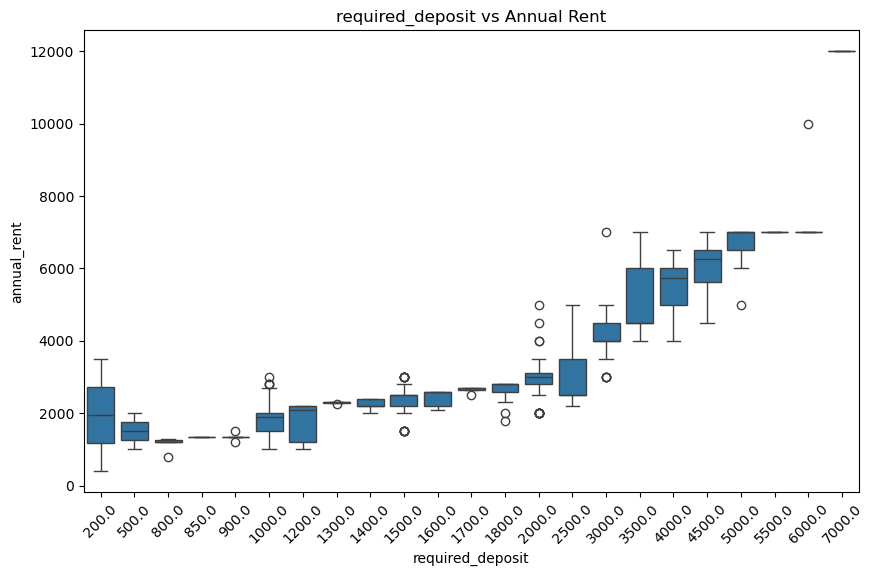

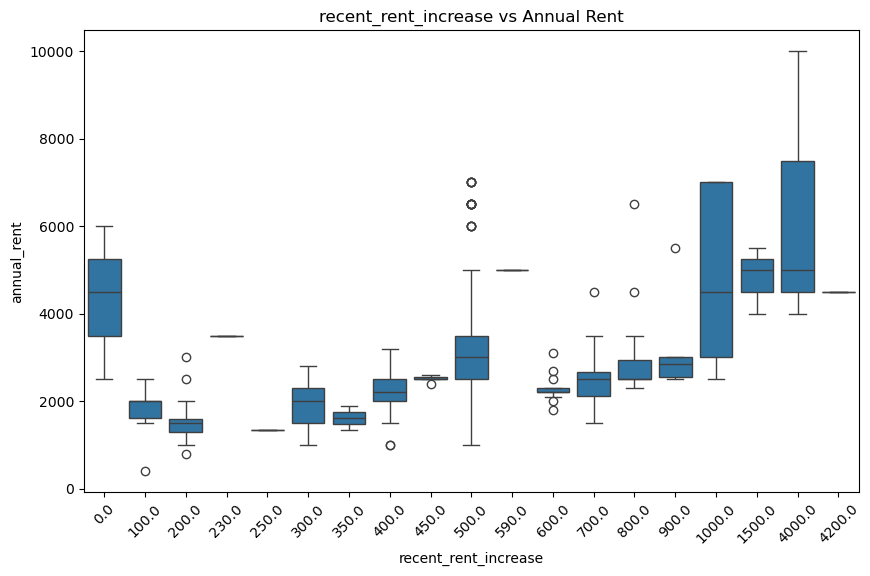

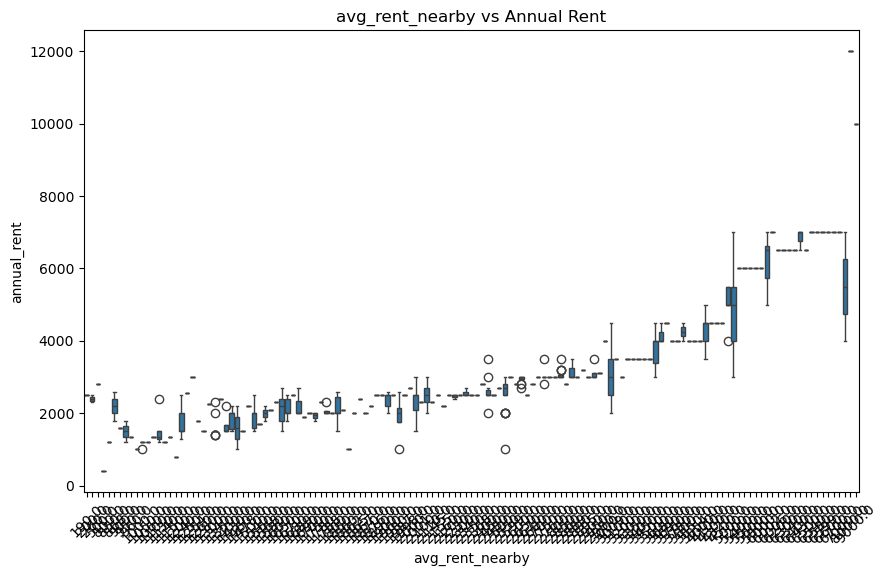

In [8]:
# Boxplots for numerical features vs. target
for col in ['required_deposit', 'recent_rent_increase', 'avg_rent_nearby']:
    if col in data.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=data[col], y=data['annual_rent'])
        plt.title(f'{col} vs Annual Rent')
        plt.xticks(rotation=45)
        plt.show()

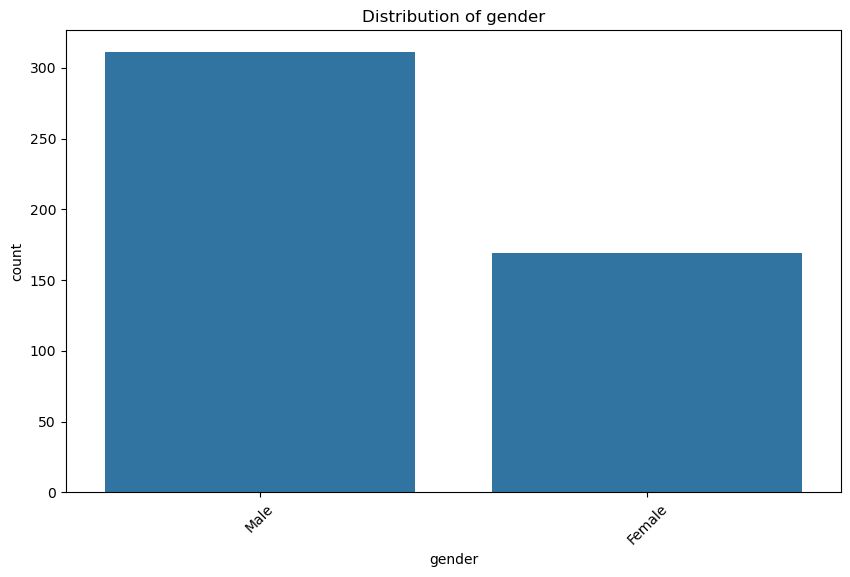

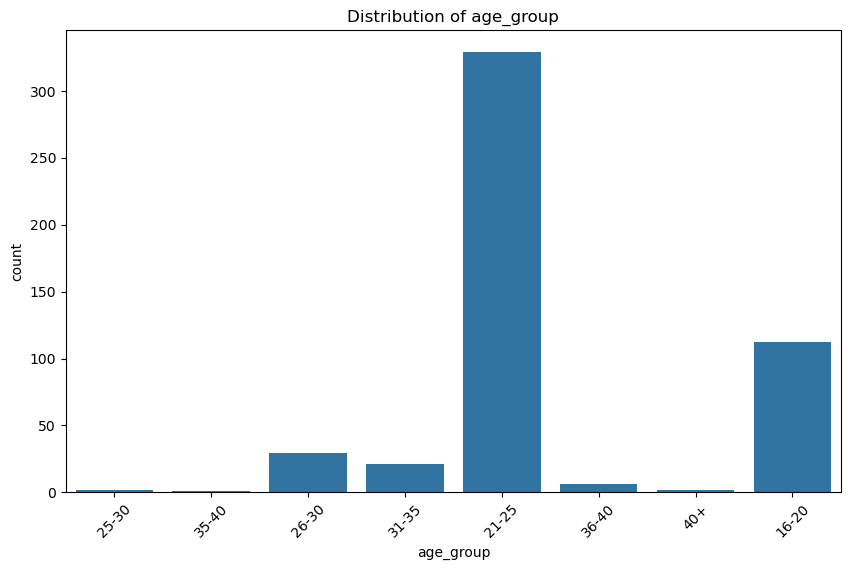

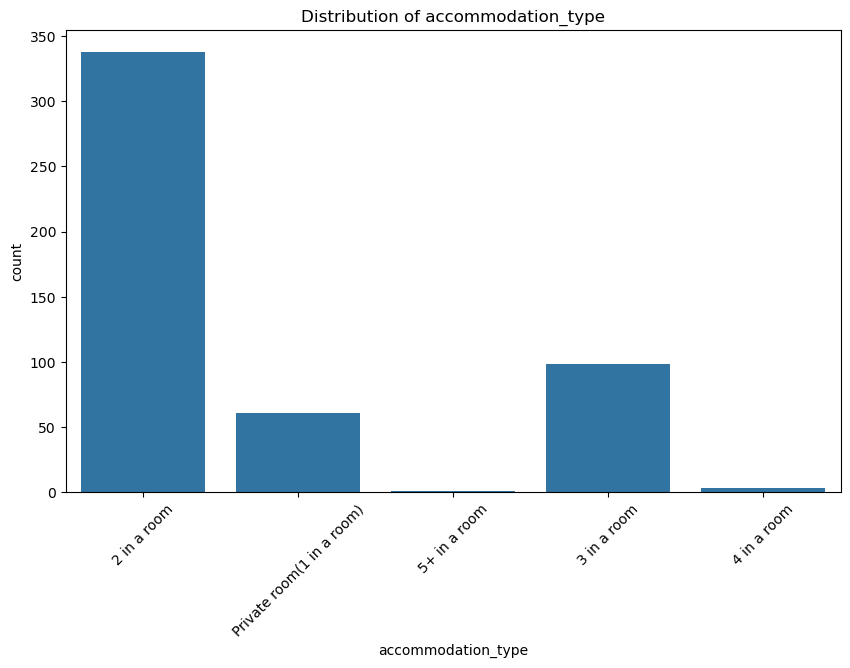

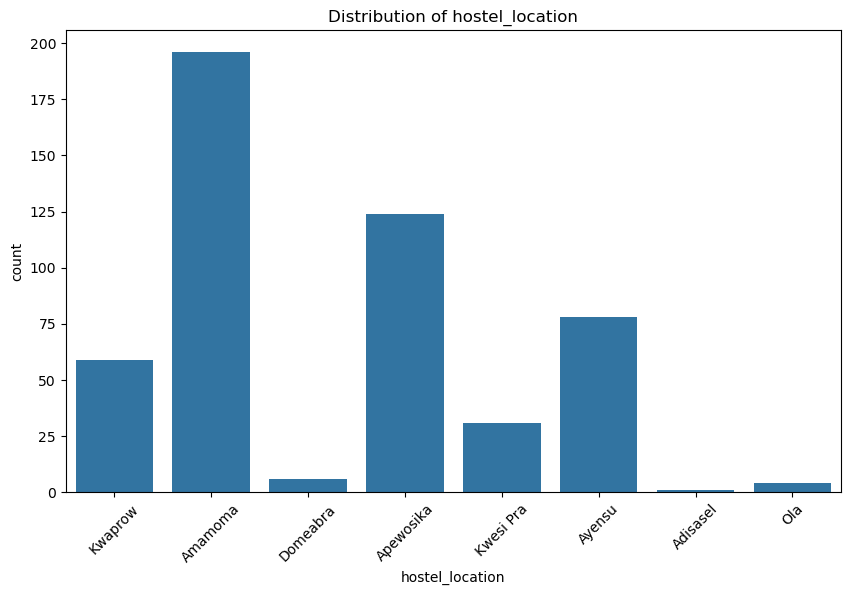

In [9]:
# Count plots for categorical features
categorical_cols = ['gender', 'age_group', 'accommodation_type', 'hostel_location']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=data[col])
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

### Data Cleaning and Handling Missing Values

In [10]:
# Rename columns for clarity and consistency
new_columns = {
    'level_of_study': 'study_level',
    'lecture_location': 'campus_location',
    'accommodation_type': 'room_type',
    'off_campus_duration': 'stay_duration',
    'includes_water': 'water_included',
    'includes_electricity': 'electricity_included',
    'includes_waste_disposal': 'waste_disposal_included',
    'has_running_water': 'running_water',
    'has_extra_storage': 'extra_storage',
    'has_wifi_internet': 'wifi',
    'has_study_area': 'study_area',
    'has_security_services': 'security',
    'has_generator_backup_power': 'generator_backup',
    'hostel_distance_minutes': 'commute_time',
    'furnished_bed': 'furnished_bed',
    'furnished_table': 'furnished_table',
    'furnished_chairs': 'furnished_chairs',
    'has_access_controls': 'access_control',
    'has_janitorial_services': 'janitorial_services',
    'required_deposit': 'deposit',
    'recent_rent_increase': 'rent_increase',
    'avg_rent_nearby': 'avg_area_rent'
}

data = data.rename(columns=new_columns)

In [11]:
# Converting boolean-like strings to actual booleans
boolean_columns = ['water_included', 'electricity_included', 'waste_disposal_included', 
                   'running_water', 'extra_storage', 'wifi', 'study_area', 'security', 
                   'generator_backup', 'furnished_bed', 'furnished_table', 
                   'furnished_chairs', 'access_control', 'janitorial_services'
                  ]
for col in boolean_columns:
    if col in data.columns:
        data[col] = data[col].map({"Yes": 1, "No": 0})
        
# Cleaning categorical variables
data['study_level'] = data['study_level'].str.replace('Post Graduate', 'Postgraduate')

### Feature Engineering

In [13]:
# Creating new features
amenity_columns = ['water_included', 'electricity_included', 'waste_disposal_included', 
                   'running_water', 'extra_storage', 'wifi', 
                   'study_area', 'security', 'generator_backup']
data['total_amenities'] = data[amenity_columns].sum(axis=1)

def parse_room_size(x):
    if not isinstance(x, str): return np.nan
    nums = re.findall(r"\d+", x)
    if len(nums)==2: return np.mean([float(n) for n in nums])
    if len(nums)==1: return float(nums[0])
    if "Above" in x: return 40.0
    if "Less" in x: return 10.0
    return np.nan

def parse_distance(x):
    if not isinstance(x, str): return np.nan
    nums = re.findall(r"\d+", x)
    if len(nums)==2: return np.mean([float(n) for n in nums])
    if len(nums)==1: return float(nums[0])
    if "61+" in x: return 65.0
    return np.nan

def parse_roommates(x):
    if not isinstance(x, str): return np.nan
    if "Private" in x or "1 in a room" in x: return 1.0
    m = re.search(r"(\d+)\s*in a room", x)
    if m: return float(m.group(1))
    if "5+" in x: return 5.0
    return np.nan

data['room_size_sqm']   = data['room_size'].apply(parse_room_size)
data['distance_minutes'] = data['commute_time'].apply(parse_distance)
data['num_roommates']   = data['room_type'].apply(parse_roommates)

## Handle Skewness

In [14]:
skewed_cols = ["annual_rent","avg_area_rent","deposit","rent_increase"]
for col in skewed_cols:
    data[f'log_{col}'] = np.log1p(data[col])

target = "log_annual_rent"

numeric_features = [
    "room_size_sqm","distance_minutes","num_roommates","total_amenities",
    "log_avg_area_rent","log_deposit","log_rent_increase"
]

categorical_features = ["gender","age_group","study_level","campus_location",
                        "faculty","stay_duration","room_category","hostel_location","commute_mode"]

boolean_features = boolean_columns

# Drop rows where target is missing
data = data.dropna(subset=["annual_rent", "log_annual_rent"]).reset_index(drop=True)

X = data[numeric_features + categorical_features + boolean_features]
y = data[target]

## Train/Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((400, 30), (100, 30))

### Preprocessing

In [16]:
# Numeric pipeline
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# Categorical pipeline
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Boolean pipeline (impute missing as 0)
bool_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0))
])

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric_features),
    ("cat", cat_pipe, categorical_features),
    ("bool", bool_pipe, boolean_features)
])


## Models & Hyperparameter Tuning

In [17]:
models = {
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective="reg:squarederror")
}

param_grids = {
    "Ridge": {"regressor__alpha": [0.1, 1.0, 10.0, 100.0]},
    "RandomForest": {
        "regressor__n_estimators": [200, 500],
        "regressor__max_depth": [10, 20, None]
    },
    "GradientBoosting": {
        "regressor__n_estimators": [200, 400],
        "regressor__learning_rate": [0.05, 0.1],
        "regressor__max_depth": [2, 3]
    },
    "XGBoost": {
        "regressor__n_estimators": [200, 400],
        "regressor__learning_rate": [0.05, 0.1],
        "regressor__max_depth": [3, 4, 5]
    }
}


## Train, Tune & Evaluate

In [18]:
best_model, best_name, best_rmse = None, None, np.inf
best_preds, best_y_true, best_params = None, None, None
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    gs = GridSearchCV(pipe, param_grids[name], cv=kf,
                      scoring="neg_root_mean_squared_error", n_jobs=-1)
    gs.fit(X_train, y_train)

    preds_log = gs.best_estimator_.predict(X_test)
    preds = np.expm1(preds_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)

    # Calculate CV RMSE from the best parameters
    cv_scores = -gs.cv_results_['mean_test_score'][gs.best_index_]
    
    print(f"\n{name} best params: {gs.best_params_}")
    print(f"Test RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}, CV RMSE={cv_scores:.2f}")

    if rmse < best_rmse:
        best_rmse, best_model, best_name = rmse, gs.best_estimator_, name
        best_preds, best_y_true, best_params = preds, y_true, gs.best_params_

print(f"\nSelected best model: {best_name} (RMSE={best_rmse:.2f})")


Ridge best params: {'regressor__alpha': 10.0}
Test RMSE=435.92, MAE=298.02, R²=0.889, CV RMSE=0.18

RandomForest best params: {'regressor__max_depth': 10, 'regressor__n_estimators': 200}
Test RMSE=392.78, MAE=224.26, R²=0.910, CV RMSE=0.15

GradientBoosting best params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 2, 'regressor__n_estimators': 200}
Test RMSE=363.84, MAE=238.51, R²=0.923, CV RMSE=0.15

XGBoost best params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Test RMSE=376.41, MAE=246.17, R²=0.917, CV RMSE=0.15

Selected best model: GradientBoosting (RMSE=363.84)


## Visualizations

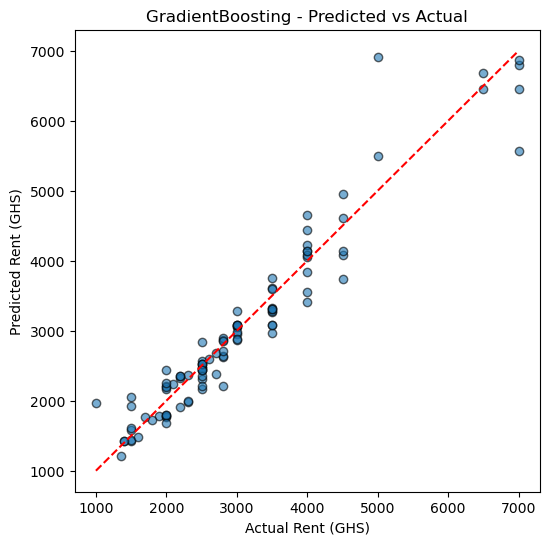

In [19]:
# Predicted vs Actual

plt.figure(figsize=(6,6))
plt.scatter(best_y_true, best_preds, alpha=0.6, edgecolors='k')
plt.plot([best_y_true.min(), best_y_true.max()],
         [best_y_true.min(), best_y_true.max()],
         color="red", linestyle="--")
plt.xlabel("Actual Rent (GHS)")
plt.ylabel("Predicted Rent (GHS)")
plt.title(f"{best_name} - Predicted vs Actual")
plt.show()

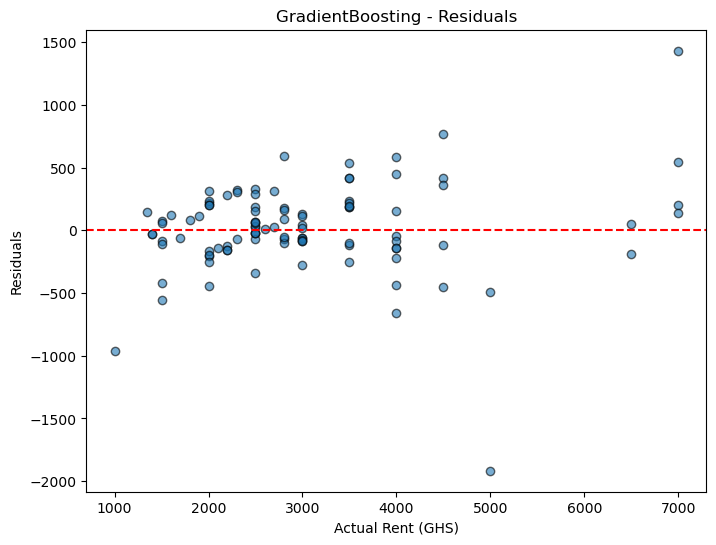

In [20]:
# Residual Plot

residuals = best_y_true - best_preds
plt.figure(figsize=(8,6))
plt.scatter(best_y_true, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual Rent (GHS)")
plt.ylabel("Residuals")
plt.title(f"{best_name} - Residuals")
plt.show()


## Feature Importance

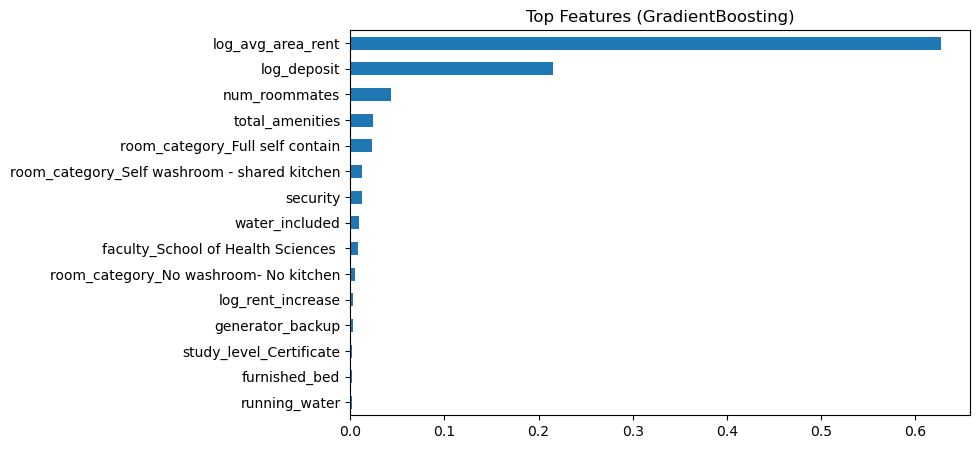

In [21]:
regressor = best_model.named_steps["regressor"]
importances = regressor.feature_importances_

ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = list(numeric_features) + cat_names + list(boolean_features)

pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15).plot(
    kind="barh", figsize=(8,5), title=f"Top Features ({best_name})")
plt.gca().invert_yaxis()
plt.show()

## SHAP Explainability

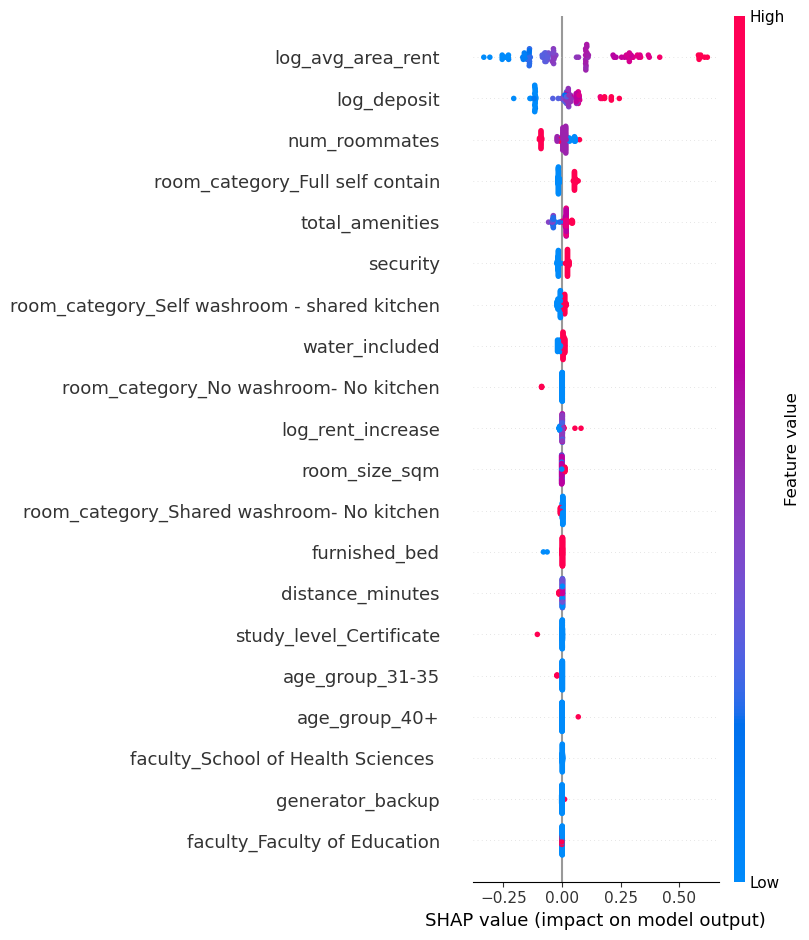

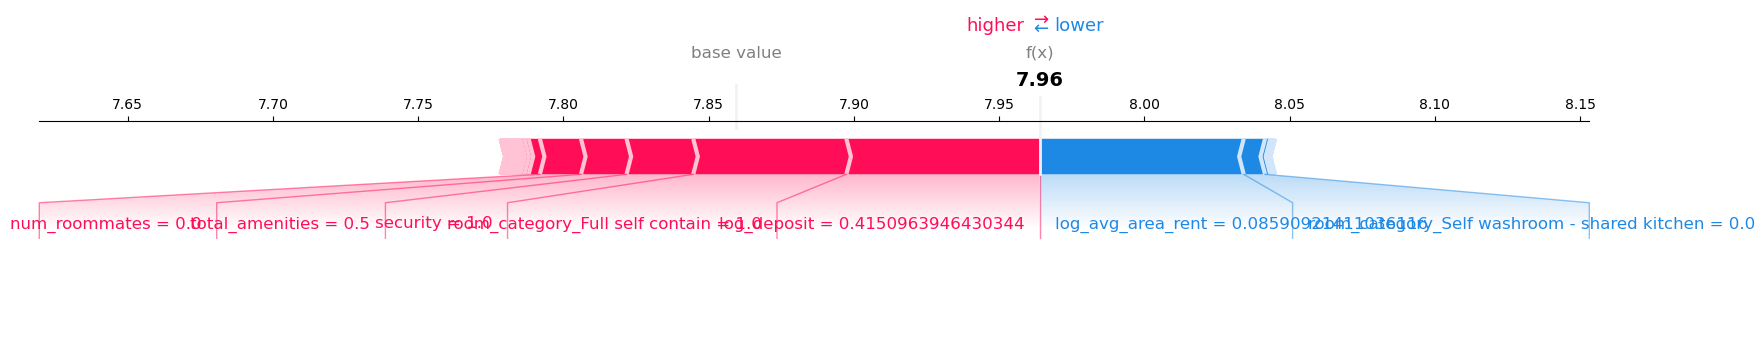

In [22]:
X_sample = X_test.sample(100, random_state=42)
pre = best_model.named_steps["preprocessor"]
X_proc = pre.transform(X_sample)

ohe = pre.named_transformers_["cat"].named_steps["encoder"]
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = list(numeric_features) + cat_names + list(boolean_features)

explainer = shap.TreeExplainer(best_model.named_steps["regressor"])
shap_values = explainer.shap_values(X_proc)

# Global summary
shap.summary_plot(shap_values, X_proc, feature_names=feature_names, show=True)

# Local force plot (first row)
shap.force_plot(explainer.expected_value,
                shap_values[0,:],
                X_proc[0,:],
                feature_names=feature_names,
                matplotlib=True)

## Save Model

In [23]:
joblib.dump(best_model, "best_hostel_rent_model.pkl")
print(f"Model saved as best_hostel_rent_model.pkl ({best_name}, {best_params})")

Model saved as best_hostel_rent_model.pkl (GradientBoosting, {'regressor__learning_rate': 0.05, 'regressor__max_depth': 2, 'regressor__n_estimators': 200})


In [24]:
# Save sample input schema
sample_input = X_train.iloc[:1].copy()
joblib.dump(sample_input, 'sample_input.pkl')

['sample_input.pkl']